In [1]:
import os
import json
import numpy as np
from skimage.draw import disk
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize
from sklearn.model_selection import LeaveOneOut
import tensorflow as tf

def create_mask_from_json(json_data, shape):
    mask = np.zeros(shape, dtype=np.float32)
    for item in json_data:
        rr, cc = disk((item['y'], item['x']), item['radius'], shape=shape)
        mask[rr, cc] = 1.0
    return mask

def resize_labels(labels, original_size, new_size):
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels

def load_images_and_labels(image_paths, label_dir, new_size):
    original_size = (1024, 1024)  # Original size of the images and labels
    images = []
    masks = []

    for image_path in image_paths:
        # Extract filename without extension to match with the label
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        label_file = os.path.join(label_dir, base_filename + '.json')

        # Load and resize image
        image = img_to_array(load_img(image_path, color_mode='rgb', target_size=new_size))
        images.append(image / 255.0)  # Normalizing to [0, 1]

        # Load and resize corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size, new_size)
        mask = create_mask_from_json(resized_json_data, shape=new_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, *new_size, 1)



def create_loocv_folds(image_files, augmented_image_dir):
    folds = []
    n = len(image_files)

    for i in range(n):
        test_image = image_files[i]
        
        # Ensure validation images are different from the test image and rotate them
        val_indices = [(i + 1) % n, (i + 2) % n]
        validation_images = [image_files[j] for j in val_indices]

        # Remaining images for training, excluding the test and validation images
        train_images = [img for idx, img in enumerate(image_files) if idx not in [i, val_indices[0], val_indices[1]]]

        # Augmented images for training
        augmented_train_images = [os.path.join(augmented_image_dir, os.path.basename(img).replace('.png', f'_aug_{k}.png')) 
                                  for img in train_images for k in range(20)]

        folds.append((augmented_train_images, [test_image], validation_images))

    return folds



In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation

def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(512, 512, 3), num_filters=16, depth=2, dropout=0.5, batch_norm=True):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)

    # FINAL CONVOLUTION
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [3]:
# Create the model
model = unet()

model.summary()

NameError: name 'Input' is not defined

In [4]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import os

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 0:
        return lr
    elif epoch < 15 and epoch%2 == 0:
        return lr * tf.math.exp(-0.2)
    elif epoch > 30:
        return lr * tf.math.exp(-0.5)
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

log_dir = "./tensorboard_logs"

def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)
    return loss

def train_unet(model, train_images, train_masks, val_images, val_masks, epochs=300, batch_size=32, checkpoint_path='pixel_cores.hdf5'):
    # Define the custom loss function
    custom_loss = weighted_binary_crossentropy(zero_weight=1, one_weight=1)

    # Check if a previous checkpoint exists
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        # Load the model with the custom loss function
        model = load_model(checkpoint_path, custom_objects={'loss': custom_loss})
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=custom_loss, metrics=['AUC', 'accuracy', 'Precision', 'Recall'])
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
    
    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)

    # Fit the model with the given training and validation data
    history = model.fit(
        x=train_images, 
        y=train_masks, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(val_images, val_masks), 
        callbacks=[model_checkpoint, tensorboard_callback, lr_scheduler, early_stopping]
    )
    
    return model



In [2]:
import os
import numpy as np
import csv  # Import the csv module

original_image_dir = './TMA_WSI_Padded_PNGs'
augmented_image_dir = './augmented_images'
original_label_dir = './TMA_WSI_Labels_updated'
augmented_label_dir = './augmented_labels'

# Use list comprehension to create the list of file paths
original_image_files = [os.path.join(original_image_dir, file) for file in sorted(
    os.listdir(original_image_dir)) if file.endswith('.png')]

folds = create_loocv_folds(original_image_files, augmented_image_dir)


In [8]:
folds[0][2]

['./TMA_WSI_Padded_PNGs/158868.png', './TMA_WSI_Padded_PNGs/158869.png']

In [ ]:
import csv

# Define the path to the CSV file
csv_file = 'model_evaluation_results.csv'

# Open the CSV file in append mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    # Iterate over each fold
    for i, fold in enumerate(folds):
        # Load the checkpointed model for the fold
        model_path = f"pixel_core_fold_{i+1}.hdf5"
        loaded_model = tf.keras.models.load_model(model_path, custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

        # Unpack the fold
        train_image, test_image, val_images = fold

        # Load the test images and masks
        test_images, test_masks = load_images_and_labels(test_image, original_label_dir, (512,512))

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = loaded_model.evaluate(test_images, test_masks)

        # Write the evaluation metrics to the CSV file
        writer.writerow([i+1, loss, auc, accuracy, precision, recall])
    

        # Flush the changes to the CSV file
        file.flush()


1/1 [==============================] - 0s 266ms/step - loss: 0.1044 - auc: 0.9940 - accuracy: 0.9804 - precision: 0.8230 - recall: 0.9236


In [11]:

# Evaluation metrics initialization
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

new_size = (512, 512)

# Open a CSV file to write the results
with open('model_evaluation_results.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    # Check if the file is empty by seeking to the end and getting the position
    file.seek(0, os.SEEK_END)
    if file.tell() == 0:
        # File is empty, write the header
        writer.writerow(['Fold', 'Loss', 'AUC', 'Accuracy', 'Precision', 'Recall'])

    file.flush() 
    indices = [14,16,19]
    # Iterate over each fold
    i = 0
    for i, fold in enumerate([folds[index - 1] for index in indices], start=1):
        augmented_train_images, test_image, validation_images = fold
        i = indices[i-1]
        # Load and preprocess images and labels
        train_images, train_masks = load_images_and_labels(
            augmented_train_images, augmented_label_dir, new_size)
        test_images, test_masks = load_images_and_labels(
            test_image, original_label_dir, new_size)
        val_images, val_masks = load_images_and_labels(
            validation_images, original_label_dir, new_size)

        # Create a new instance of the model
        model = unet()

        # Train the model
        trained_model = train_unet(model, train_images, train_masks, val_images, val_masks, 150, 32, "pixel_core_fold_{i}.hdf5".format(i=i))

        # Evaluate the model on the test set
        loss, auc, accuracy, precision, recall = trained_model.evaluate(
            test_images, test_masks)

        # Store the evaluation metrics
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)

        # Write the fold results to the CSV file
        writer.writerow([i, loss, auc, accuracy, precision, recall])
        file.flush() 

KeyboardInterrupt: 

In [9]:
import pandas as pd

results = pd.read_csv('model_evaluation_results.csv') 

results.describe()

,Fold,Loss,AUC,Accuracy,Precision,Recall
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,10.000000,0.173526,0.979902,0.944278,0.857093,0.878364
std,5.627314,0.057366,0.016022,0.021369,0.081105,0.092810
min,1.000000,0.089000,0.934922,0.891060,0.703799,0.668352
25%,5.500000,0.134935,0.977651,0.931433,0.801033,0.823237
50%,10.000000,0.153797,0.985674,0.948444,0.877027,0.920812
75%,14.500000,0.203283,0.989798,0.956776,0.911463,0.930040
max,19.000000,0.306458,0.993985,0.980431,0.980146,0.989105


In [8]:
import numpy as np
from scipy.ndimage import label, find_objects, center_of_mass, measurements
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2



def connected_component_labeling(data):
    """
    Apply Connected Component Labeling to a binary image array and return the properties of detected objects.
    
    Parameters:
    - data: A numpy array representing the binary image, where 'True' are the objects and 'False' is the background.
    
    Returns:
    - A dictionary containing the properties of each detected object.
    """
    labeled_array, num_features = label(data)
    centers = center_of_mass(data, labeled_array, range(1, num_features+1))
    areas = [np.sum(labeled_array == i) for i in range(1, num_features+1)]

    properties = {}
    for i in range(num_features):
        properties[i+1] = {
            'center': centers[i],
            'area': areas[i],
        }
    
    return properties


from skimage import measure

def segmentationAlgorithm(data, min_area, max_area, dis_transform_multiplier=0.6):

    
    # Noise removal with opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(data.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (dilation enlarges the regions)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (distance transform gives regions of sure foreground)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, dis_transform_multiplier * dist_transform.max(), 255, 0)

    # Finding unknown region (subtracting sure foreground from sure background)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0


    # Calculate properties for each region. Note that watershed marks boundaries with -1, so we skip it.
    properties = {}
    for region in measure.regionprops(markers, intensity_image=data):
        if region.label <= 0:  # Skip watershed boundary regions and background
            continue
        if region.area >= min_area and region.area <= max_area:  # Filter by minimum area
            properties[region.label] = {
                'center': region.centroid,
                'area': region.area,
                # More properties can be added here as needed
            }

    return properties


def visualize_detection_results(data, properties):
    """
    Visualize the results of the Connected Component Labeling on the original image.
    
    Parameters:
    - data: A numpy array representing the binary image used for CCL.
    - properties: A dictionary containing the properties of each detected object.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(data.squeeze(), cmap='gray')

    for prop_id, prop in properties.items():
        y, x = prop['center']
        ax.plot(x, y, 'ro')  # Red dot for the center

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Function to visualize the steps of the watershed segmentation process
def visualize_watershed_steps(data):
    # Noise removal with opening
    kernel = np.ones((4, 4), np.uint8)
    opening = cv2.morphologyEx(data.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (dilation enlarges the regions)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (distance transform gives regions of sure foreground)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

    # Finding unknown region (subtracting sure foreground from sure background)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed
    watershed = cv2.watershed(cv2.cvtColor(data.astype(np.uint8), cv2.COLOR_GRAY2BGR), markers)

    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    ax = axes.ravel()

    ax[0].imshow(data, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Show the markers on top of the original image
    ax[1].imshow(markers, cmap='gray', alpha=0.5)
    # ax[1].imshow(data, cmap='gray')
    ax[1].set_title('Original image with initial markers')
    ax[1].axis('off')

    ax[2].imshow(opening, cmap='gray')
    ax[2].set_title('After Opening')
    ax[2].axis('off')

    ax[3].imshow(sure_bg, cmap='gray')
    ax[3].set_title('Sure Background')
    ax[3].axis('off')

    ax[4].imshow(dist_transform, cmap='gray')
    ax[4].set_title('Distance Transform')
    ax[4].axis('off')

    ax[5].imshow(watershed, cmap='jet')
    ax[5].set_title('After Watershed')
    ax[5].axis('off')

    plt.tight_layout()
    plt.show()

    return watershed


1/1 [==============================] - 0s 162ms/step


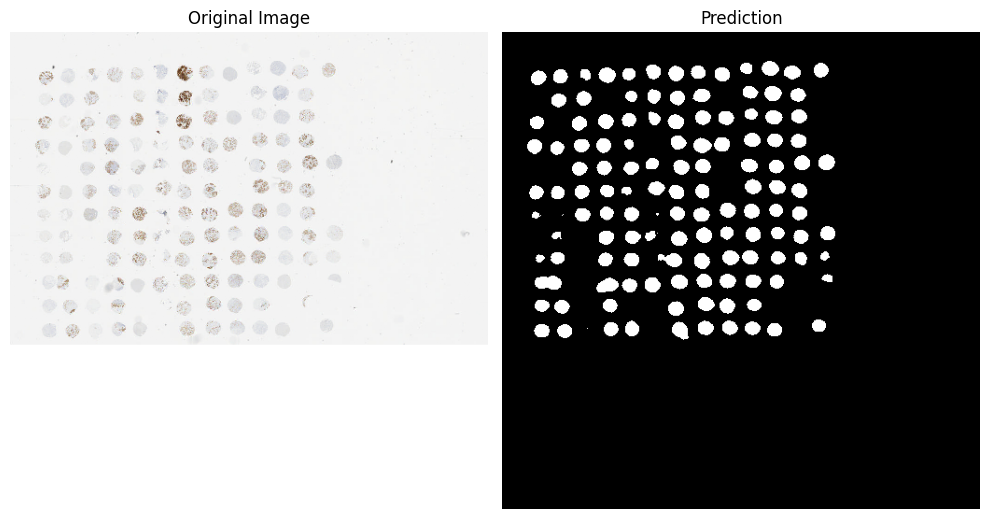

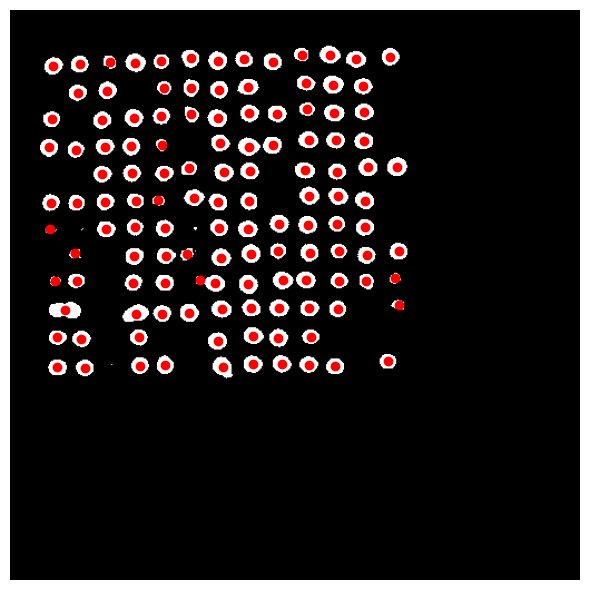

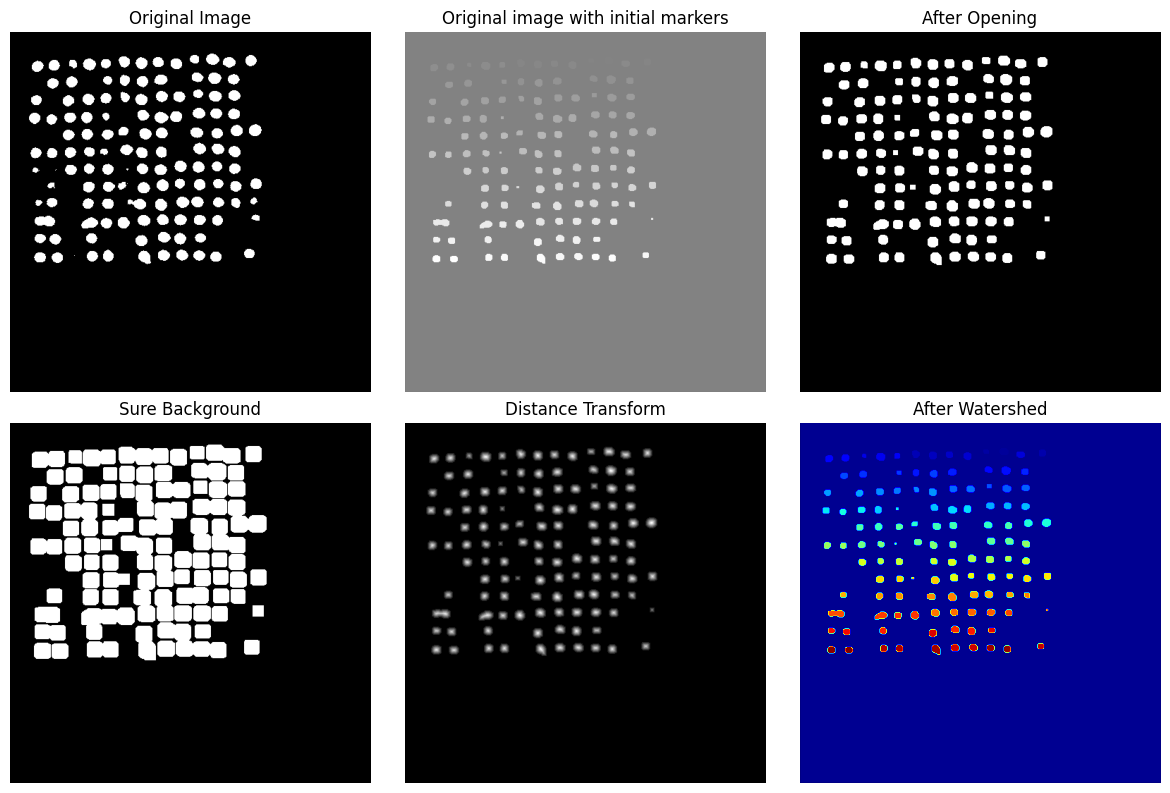

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [18]:
import matplotlib.pyplot as plt 
def plot_predictions_for_fold(model, fold_index, test_images, test_masks, threshold = 0.975):
    # Make predictions on the test set
    predictions = model.predict(test_images)
    predictions = predictions > threshold
    # Plot the original images and their corresponding predictions
    fig, axes = plt.subplots(len(test_images), 2, figsize=(10, 10))
    for i, (image, mask, prediction) in enumerate(zip(test_images, test_masks, predictions)):
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(prediction.squeeze(), cmap='gray')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return predictions

# Assuming the create_loocv_folds function returns a list of folds
folds = create_loocv_folds(original_image_files, augmented_image_dir)

# Assuming the 10th fold is at index 9
fold_index = 5

# Assuming the 10th fold contains test images and masks
test_images = folds[fold_index][1]

test_image, test_mask = load_images_and_labels(test_images, original_label_dir, (512,512))

# Assuming the 10th fold model is stored in a variable called "model_10"
model_10 = tf.keras.models.load_model("./Saved_Models/pixel_core_fold_10.hdf5", custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})


# Plot the predictions for the 10th fold
results = np.squeeze(plot_predictions_for_fold(model_10, fold_index, test_image, test_mask, 0.92))

object_detection_results = segmentationAlgorithm(results,3, 1000, 0.1)
visualize_detection_results(results, object_detection_results)


visualize_watershed_steps(results)

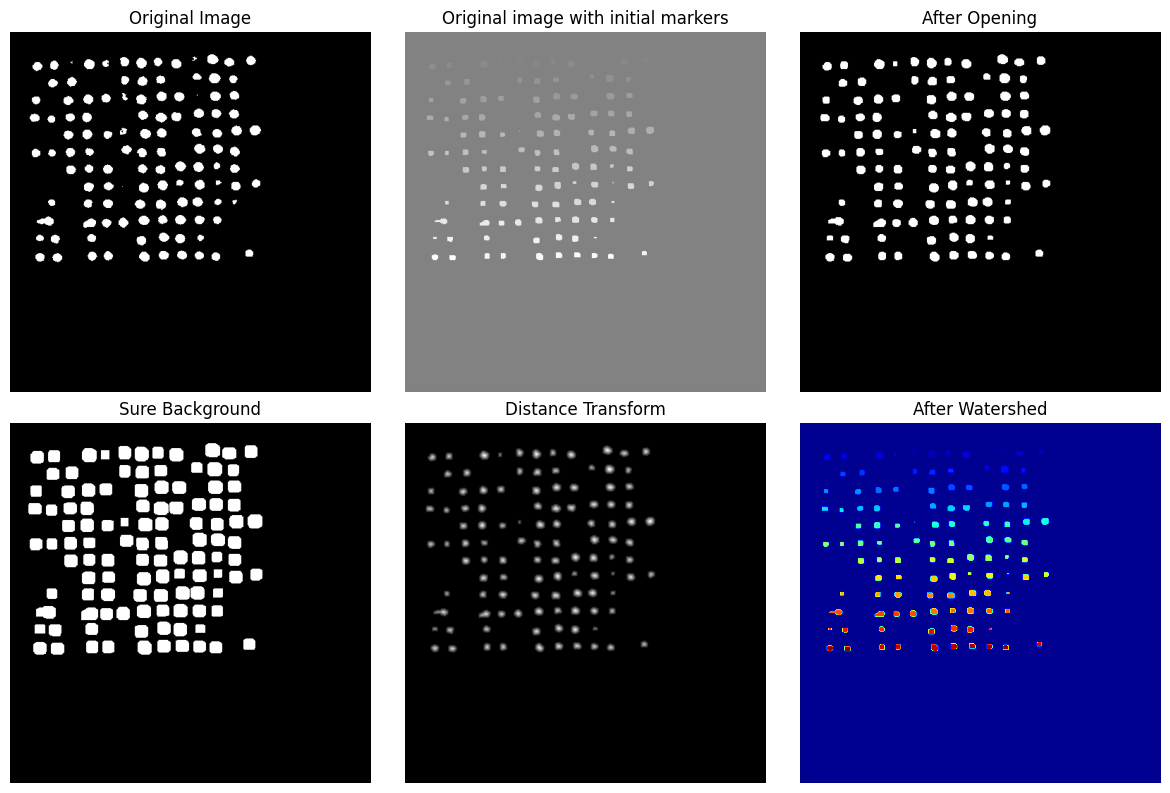

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

In [14]:
# Assuming the create_loocv_folds function returns a list of folds
folds = create_loocv_folds(original_image_files, augmented_image_dir)

# Get the augmented training images and validation images
augmented_train_images = folds[0][0]
validation_images = folds[0][2]

augmented_test_images = []
for image_path in folds[0][1]:
    for i in range(20):
        augmented_image_path = os.path.join(augmented_image_dir, f"{os.path.basename(image_path).split('.')[0]}_aug_{i}.png")
        augmented_test_images.append(augmented_image_path)

augmented_train_images.extend(augmented_test_images)


# # Load and preprocess the augmented training images and validation images
train_images, train_masks = load_images_and_labels(augmented_train_images, augmented_label_dir, (512, 512))
val_images, val_masks = load_images_and_labels(validation_images, original_label_dir, (512, 512))

# Create a new instance of the model
model = load_model("./Saved_Models/pixel_core_fold_1.hdf5", custom_objects={'loss': weighted_binary_crossentropy(zero_weight=1, one_weight=1)})

# Train the model
# trained_model = train_unet(model, train_images, train_masks, val_images, val_masks, 150, 32, "final_segmentation_model.hdf5".format(i=i))
